# Introduction

MedGemma is a multimodal specialized model from Google DeepMind. It is based on Gemma 3 model.

It has multiple utilizations, including:
- Medical image classification - can be used to classiffy images of various modalities: radiology, digital pathology, fundus and skin images.
- Medical image interpretation - can interpret a variety of medical images (various radiologic modalities as well as protocols) and answer natural language questions about medical images.
- Medical text comprehension and clinical reasoning - for most use cases, the larger 27B model will yields the best performance but also the 4B model can achieve good results.

This Notebook will demonstrate use of the MedGemma model to convert medical transcripts to SOAP format.

## What is SOAP note format?

SOAP is an achronim that stands for:
* **Subjective** - what the patient says.
* **Objective** - what the clinician observes or measures.
* **Assessment** - the diagnosis or differential diagnosis.
* **Procedure** - next steps: treatment, tests, follow-ups, patient education.

The **SOAP** note provides a structured and consistent way for healthcare providers to document and communicate patient encounters, ensuring that both subjective symptoms and objective evidence are clearly organized.




# Prerequisites

Gemma 3 is supported from transformers 4.50.0. If your Notebook is preinstalled with an earlier version, you will need to upgrage transformers library:

```pip install -U transformers```


In [1]:
import os
import torch
import requests
from PIL import Image
import numpy as np
from transformers import pipeline
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

2025-05-25 16:08:13.000393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748189293.193342      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748189293.251622      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load the model

We will load the model from HuggingFace, since at the time when this Notebook was written, the model is not yet published on Kaggle.

The model is protected, therefore you will have to:

- Authenticate before accessing.
- Accept the terms and conditions to use it.
  
You have few alternatives to access the model. On Kaggle, it is most convenient to use a access token, generated from HuggingFace and stored as a secret using `kaggle_secrets`.

## Authenticate to access the model

In [2]:
user_secrets = UserSecretsClient()
hugging_face_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")

After you load the secret, you can login using huggingface_hub login function and with the authentication token as parameter.

In [3]:
login(hugging_face_token)

## Define a model pipeline

Once authenticated, we can use transformers pipeline to initialize the model. In the pipeline initialization, we specify the mode `text-to-text`. For the application we need to implement, we will not need to include image as input.

In [4]:
pipe = pipeline(
    "image-text-to-text",
    model="google/medgemma-4b-it",
    torch_dtype=torch.bfloat16,
    device="cuda",
)

config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Device set to use cuda


# Load a medical transcript

We initialize a string variable with a medical transcript example.

In [5]:
medical_transcript = """
Physician: Good morning, Ms. Johnson. What brings you in today?

Patient: Morning, doctor. I’ve been having this persistent cough for the last two weeks. It started out dry, but now there’s some phlegm.

Physician: I see. Any fever or chills?

Patient: Yes, I had a mild fever three days ago, around 100.5°F, but it went away on its own.

Physician: Any shortness of breath or chest pain?

Patient: Not really chest pain, but my chest feels a bit tight, especially when I’m coughing a lot.

Physician: How about your energy levels or appetite?

Patient: I’ve been more tired than usual, and I haven’t had much of an appetite.

Physician: Any recent travel or contact with anyone who’s been sick?

Patient: No travel, but my son had a cold last week.

Physician: Okay. Let’s take a listen to your lungs.

[Stethoscope exam sounds]

Physician: I’m hearing some mild crackles in your lower lungs. No wheezing, which is good. I’ll check your oxygen level—98%, that’s normal.

Physician: I’d like to order a chest X-ray to rule out pneumonia, and we’ll also do a CBC and test for respiratory viruses. In the meantime, I’ll prescribe an inhaler to help with the chest tightness, and a cough suppressant so you can rest.

Patient: Sounds good. Should I stay home from work?

Physician: Yes, for at least a couple of days until the results come in and you’re feeling better. Stay hydrated, and rest as much as you can.

Patient: Will do. Thanks, doctor.

Physician: You’re welcome. We’ll follow up as soon as we have the test results.
"""

## Query the model

We prepare the model instructions.

First, let's prepare the system prompt. This will instruct the model to perform the conversion from a medical transcript to a SOAP format.


In [6]:
system_prompt = """
You are a clinical documentation assistant. Your task is to read medical transcripts 
(dialogues between clinicians and patients) and convert them into structured clinical notes using the SOAP format.

Follow these rules:

*S – Subjective*:
Include all information reported by the patient: symptoms, duration, history, complaints, and any relevant lifestyle or 
exposure context. Use the patient’s own words when possible (paraphrased for clarity).

*O – Objective*:
Include observable findings such as vital signs, physical exam results, lab tests, imaging results, and clinician 
observations during the encounter.

*A – Assessment*:
Provide a brief summary of the clinician’s diagnostic impression. Include possible or confirmed diagnoses.

*P – Plan*:
Outline the next steps recommended by the clinician. This can include prescriptions, tests to be ordered, 
referrals, follow-up instructions, and lifestyle recommendations.

Keep the format clear and professional. Do not include any parts of the transcript that are irrelevant or 
non-clinical. Do not invent information not found in the transcript. 
Allways use a bullet point format for each section of the SOAP note.

A comprehensive SOAP note has to take into account all subjective and objective information, 
and accurately assess it to create the patient-specific assessment and plan.

Here is the transcript from a medical record file from which you will be asked to extract relevant SOAP information:



"""

Let's initialize an empty image, since our pipeline will need also an image as input.

In [7]:
dummy_image = Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8))

In [8]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": system_prompt}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": medical_transcript},
             {"type": "image", "image": dummy_image}
            
        ]
    }
]


In [9]:
output = pipe(text=messages, max_new_tokens=512)

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Let's print the formated output:

In [10]:
display(Markdown(output[0]["generated_text"][-1]["content"]))

**S**

*   Patient presents with a persistent cough for two weeks, initially dry, now with some phlegm.
*   Mild fever (100.5°F) three days ago, resolved spontaneously.
*   Chest tightness, especially with coughing.
*   Increased fatigue and decreased appetite.
*   No recent travel.
*   Son had a cold last week.

**O**

*   Mild crackles in lower lungs upon auscultation.
*   Oxygen saturation 98% on room air.
*   No wheezing noted.

**A**

*   Possible bronchitis or pneumonia. Further investigation with chest X-ray, CBC, and respiratory viral testing is warranted.

**P**

*   Order chest X-ray.
*   Order CBC.
*   Order respiratory viral testing.
*   Prescribe an inhaler for chest tightness.
*   Prescribe a cough suppressant.
*   Advise patient to stay home from work for at least two days until test results are available.
*   Instruct patient to stay hydrated and rest.
*   Follow-up as soon as test results are available.


Let's now use an image as the medical transcript.

In [11]:
image_path = "/kaggle/input/medical-transcript-example/medical_transcript.png"
image = Image.open(image_path)

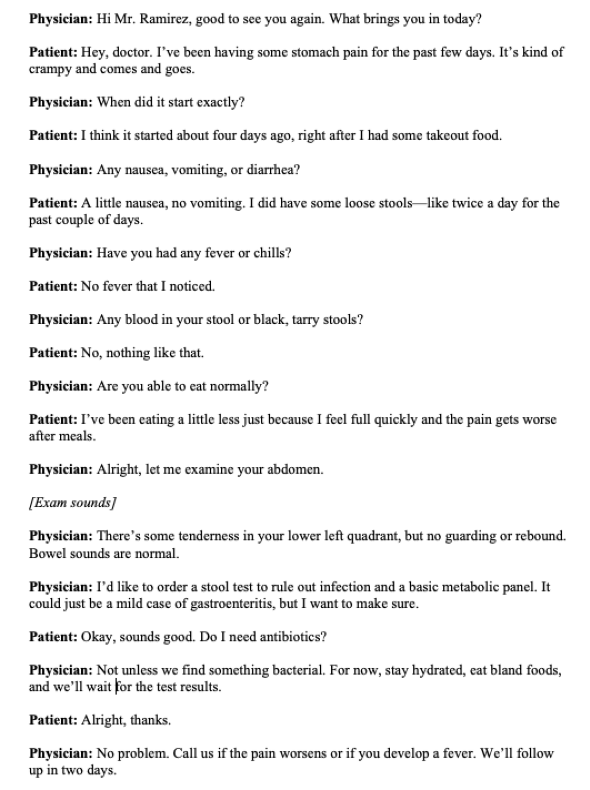

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
ax.axis('off')
plt.show()

In [13]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": system_prompt}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": ""},
            {"type": "image", "image": image},
        ]
    }
]

In [14]:
output = pipe(text=messages, max_new_tokens=512)

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


In [15]:
display(Markdown(output[0]["generated_text"][-1]["content"]))

Here is a SOAP note based on the provided transcript:

**S (Subjective)**

*   Patient reports having stomach pain for the past few days.
*   The pain is cramping and comes and goes.
*   The patient attributes the onset of the pain to eating takeout food about four days ago.
*   Patient reports nausea and loose stools.
*   Patient denies fever or chills.
*   Patient denies blood in stool or black, tarry stools.
*   Patient reports being able to eat a little but feels full quickly and the pain gets worse after meals.
*   Patient states he is not feeling up to eating.

**O (Objective)**

*   Abdominal tenderness in the lower left quadrant.
*   Normal bowel sounds.

**A (Assessment)**

*   Possible gastroenteritis.

**P (Plan)**

*   Order a stool test to rule out infection and a basic metabolic panel.
*   Consider it as a mild case of gastroenteritis but wants to rule out other possibilities.
*   Not prescribe antibiotics at this time unless something bacterial is found.
*   Advise patient to stay hydrated and eat bland foods.
*   Follow up in two days.
*   Instruct patient to call if the pain worsens or if fever develops.


# Conclusions

We created a medical transcript to SOAP format solution based on **MedGemma** model. 

We tested the solution with medical transcript provided as text format or as an image with a text.

The model is able to generate a correct SOAP format in boths cases.